In [308]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import cv2

## TASK-2

In [ ]:
def visualize_bboxes(img,df):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(img_2)

In [ ]:
def make_connections(image,df):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in df.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_box'][1])
      bottom_adjacent_id = int(row['Bottom_box'][1])
      left_adjacent_id = int(row['Left_box'][1])
      right_adjacent_id = int(row['Right_box'][1])

      if top_adjacent_id != 0:
          top_adjacent_row = df[df['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = df[df['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = df[df['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = df[df['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

In [309]:
class KDE:
    def __init__(self,kernel):
        self.kernel=kernel
    def fit(self,data):
        self.data_dim=len(data.shape)
        self.data=data
        n=data.shape[0]
        d=self.data_dim
        if self.data_dim==1:
            std_dev = np.std(data)
            h = (4 * std_dev ** 5 / (3 * n)) ** (1/5)
        else:
            cov_matrix = np.cov(data, rowvar=False)
            h = (4 / ((d + 2) * n)) ** (1 / (d + 4)) * np.linalg.det(cov_matrix) ** (1 / (d + 4))
        self.bandwidth=h
    def pseudo_log_likelihood(self):
        lst=np.linspace(0.1,1,2)
        best_score=-np.inf
        best_bandwidth=None
        for bandwidth in lst:
            total_prob=0
            self.bandwidth=bandwidth
            for _ in self.data:
                total_prob+=np.sum(self.score_samples(self.data))
                if self.kernel=='gaussian':
                    total_prob-=(1/((2*np.pi)**(self.data_dim*0.5)))
                elif self.kernel=='box':
                    total_prob-=1          
            avg_score=total_prob/len(self.data.shape)
            if avg_score > best_score:
                best_score = avg_score
                best_bandwidth = bandwidth
        return best_bandwidth
    def gaussian_score(self,x):
        return (1/((2*np.pi)**(self.data_dim*0.5)))*np.exp(-0.5*np.sum(np.square(x)))
    def box_score(self,x):
        y=np.abs(x)<1/2
        y=y.astype(int)
        if self.data_dim==1 and y==1:
            return 1
        elif self.data_dim!=1 and np.sum(y)==x.shape[0]:
            return 1
        return 0
    def triangle_score(self,x):
        prob=((-2*x)/self.bandwidth)+1
        prob=np.where(x>=self.bandwidth/2,0,prob)
        return np.prod(prob)
    def kernel_score(self,p):
        if self.kernel=='gaussian':
            score=0
            for x in self.data:
                score+=self.gaussian_score((p-x)/self.bandwidth)
            return score
        elif self.kernel=='box':
            score=0
            for x in self.data:
                score+=self.box_score((p-x)/self.bandwidth)
            return score
        else:
            score=0
            for x in self.data:
                score+=self.triangle_score(abs(p-x)/self.bandwidth)
            return score
    def score_samples(self,testdata):
        ans=[]
        for point in testdata:
            ans.append(self.kernel_score(point)/(self.data.shape[0]*(self.bandwidth**self.data_dim)))
        return ans
    def visualise(self,dt,den):
        if self.data_dim>2:
            return
        if self.data_dim==1:
            sorted_indices = np.argsort(dt)
            den=np.array(den)
            sorted_points = dt[sorted_indices]
            sorted_probabilities = den[sorted_indices]
            plt.figure(figsize=(8, 6))
            plt.scatter(sorted_points.tolist(), [0]*len(sorted_points.tolist()))
            plt.plot(sorted_points.tolist(), sorted_probabilities.tolist(),marker='x')
            plt.xlabel('Samples')
            plt.ylabel('Density')
            plt.title('Samples with Corresponding Densities')
            plt.show()
        else:
            den=np.array(den)
            x = np.linspace(min(dt[:, 0]), max(dt[:, 0]), 100)
            y = np.linspace(min(dt[:, 1]), max(dt[:, 1]), 100)
            X, Y = np.meshgrid(x, y)
            Z = np.zeros_like(X)
            for i in range(len(dt)):
                Z += den[i] * np.exp(-((X - dt[i, 0])**2 + (Y - dt[i, 1])**2))
            plt.contourf(X, Y, Z, cmap='viridis')
            plt.colorbar()
            plt.scatter(dt[:, 0], dt[:, 1], c=den, cmap='viridis', edgecolors='black')
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title('Heatmap of density for each point')
            plt.show()

In [310]:
df=pd.read_csv('csv/TLBR_250.csv')
print(df)
def convert_to_list(s):
    return ast.literal_eval(s)
columns_with_strings = ['Top-Left', 'Bottom-Right']
for column in columns_with_strings:
    df[column] = df[column].apply(convert_to_list)

      Unnamed: 0      Top-Left  Bottom-Right    Id
0              0    [225, 109]    [379, 150]     0
1              1    [396, 109]    [655, 157]     1
2              2    [665, 109]    [902, 161]     2
3              3    [952, 103]   [1034, 157]     3
4              4   [1042, 106]   [1105, 150]     4
...          ...           ...           ...   ...
1063        1063  [2183, 3268]  [2226, 3312]  1063
1064        1064  [2238, 3271]  [2306, 3312]  1064
1065        1065  [2315, 3268]  [2376, 3309]  1065
1066        1066   [208, 3356]   [261, 3397]  1066
1067        1067   [290, 3367]   [309, 3394]  1067

[1068 rows x 4 columns]


In [311]:
df['Bottom-Left'] = [[tl[0], br[1]] for tl, br in zip(df['Top-Left'], df['Bottom-Right'])]
df['Top-Right'] = [[br[0], tl[1]] for tl, br in zip(df['Top-Left'], df['Bottom-Right'])]
df['Left'] = [[tl[0], int((tl[1]+br[1])/2)] for tl, br in zip(df['Top-Left'], df['Bottom-Left'])]
df['Right'] = [[br[0], int((tl[1]+br[1])/2)] for tl, br in zip(df['Top-Right'], df['Bottom-Right'])]
df['Top'] = [[int((tl[0]+br[0])/2), br[1]] for tl, br in zip(df['Top-Left'], df['Top-Right'])]
df['Bottom'] = [[int((tl[0]+br[0])/2), tl[1]] for tl, br in zip(df['Bottom-Left'], df['Bottom-Right'])]
lst=['Left','Right','Top','Bottom']
for l in lst:
    df[l]=df[l].apply(np.array)
data=df[lst].values
print(data.shape)
print(df)

(1068, 4)
      Unnamed: 0      Top-Left  Bottom-Right    Id   Bottom-Left  \
0              0    [225, 109]    [379, 150]     0    [225, 150]   
1              1    [396, 109]    [655, 157]     1    [396, 157]   
2              2    [665, 109]    [902, 161]     2    [665, 161]   
3              3    [952, 103]   [1034, 157]     3    [952, 157]   
4              4   [1042, 106]   [1105, 150]     4   [1042, 150]   
...          ...           ...           ...   ...           ...   
1063        1063  [2183, 3268]  [2226, 3312]  1063  [2183, 3312]   
1064        1064  [2238, 3271]  [2306, 3312]  1064  [2238, 3312]   
1065        1065  [2315, 3268]  [2376, 3309]  1065  [2315, 3309]   
1066        1066   [208, 3356]   [261, 3397]  1066   [208, 3397]   
1067        1067   [290, 3367]   [309, 3394]  1067   [290, 3394]   

         Top-Right          Left         Right           Top        Bottom  
0       [379, 109]    [225, 129]    [379, 129]    [302, 109]    [302, 150]  
1       [655, 109] 

#### Centre left edge to centre right edge distances

In [312]:
n_samples = data.shape[0]
distances = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        distances[i, j] = np.linalg.norm(data[i, 0] - data[j, 1])
min_indices = np.argmin(distances, axis=1)
min_values = np.min(distances, axis=1)
indices_and_values = np.column_stack((min_indices, min_values))
indices_and_values[:,0] = indices_and_values[:,0].astype(int)
# sorted_indices = np.argsort(indices_and_values[:, 1])
l_to_rdist=indices_and_values

#### Centre right to centre left edge distances

In [313]:
n_samples = data.shape[0]
distances = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        distances[i, j] = np.linalg.norm(data[i, 1] - data[j, 0])
min_indices = np.argmin(distances, axis=1)
min_values = np.min(distances, axis=1)
indices_and_values = np.column_stack((min_indices, min_values))
indices_and_values[:,0] = indices_and_values[:,0].astype(int)
# sorted_indices = np.argsort(indices_and_values[:, 1])
r_to_ldist=indices_and_values

#### KDE for Horizontal Threshold

[8.637373944566439e-05, 0.016789881610831513, 0.03785453638352087, 0.0053535510219754725, 0.04098212778751491, 0.041678745208778054, 0.04091442610527406, 0.002045377957795815, 0.0005908336520833001, 0.03280676877901237, 0.0021262751765909714, 0.041678745208778054, 0.004309942177296559, 0.036948456697330455, 0.03551755349613732, 0.005124231620928061, 0.004783432264726463, 0.036544985548939785, 0.005062994827168288, 0.04161836147158374, 0.041678745208778054, 0.04131405983867648, 0.003140787383399288, 0.03785453638352087, 0.004988638451047107, 0.03797939625477015, 0.04135014299918773, 0.03316382366482616, 0.04115334070925164, 0.04091442610527406, 0.04058613927532053, 6.453369383423358e-05, 0.03880318798535323, 0.04058613927532053, 0.005081493241303857, 0.04091442610527406, 0.038168091134159546, 0.04058394425084973, 0.04161836147158374, 0.037318469865578255, 0.005081986997899827, 0.037318469865578255, 0.03280676877901237, 0.03316382366482616, 0.0004523512808289528, 0.04161836147158374, 0.0

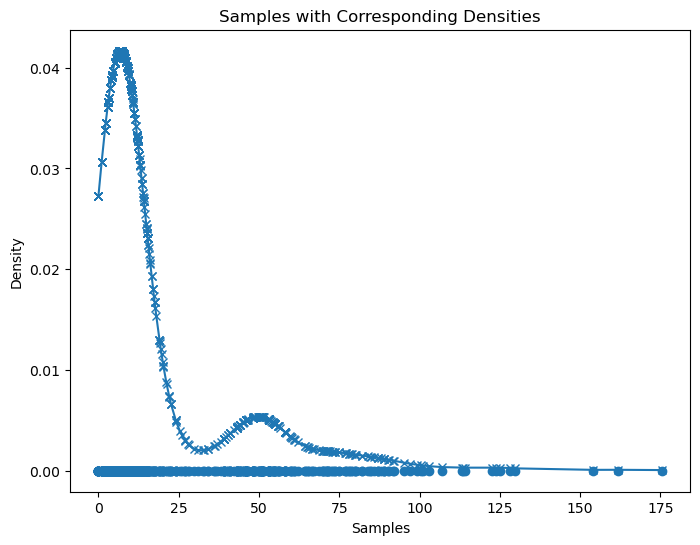

In [314]:
cl=KDE('gaussian')
cl.fit(l_to_rdist[:,1])
out=cl.score_samples(l_to_rdist[:,1])
print((out))
cl.visualise(l_to_rdist[:,1],out)

In [315]:
ind_peak=out.index(max(out))
dist_peak=(l_to_rdist[:,1])[ind_peak]
threshold_horizontal=2*dist_peak
print(threshold_horizontal)

13.416407864998739


#### So, we can remove the connection between the boxes having the distance greater than threshold.

#### Centre top to centre bottom edge distances

In [316]:
n_samples = data.shape[0]
distances = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        distances[i, j] = np.linalg.norm(data[i, 2] - data[j, 3])
min_indices = np.argmin(distances, axis=1)
min_values = np.min(distances, axis=1)
indices_and_values = np.column_stack((min_indices, min_values))
indices_and_values = indices_and_values.astype(int)
# sorted_indices = np.argsort(indices_and_values[:, 1])
t_to_bdist=indices_and_values

#### Centre bottom to centre top edge distance

In [317]:
n_samples = data.shape[0]
distances = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        distances[i, j] = np.linalg.norm(data[i, 3] - data[j, 2])
min_indices = np.argmin(distances, axis=1)
min_values = np.min(distances, axis=1)
indices_and_values = np.column_stack((min_indices, min_values))
indices_and_values = indices_and_values.astype(int)
# sorted_indices = np.argsort(indices_and_values[:, 1])
b_to_tdist=indices_and_values

#### KDE for Vertical Threshold

[0.003711278662903418, 0.0052731197751490575, 0.005228869983877675, 0.004903158235723699, 0.004545119034027114, 0.005319885263045358, 0.003083791448588872, 0.002045377957795815, 0.0034218794842044995, 0.005153810881157157, 0.003524562111503203, 0.0034218794842044995, 0.02719638571750594, 0.003524562111503203, 0.015380879453082242, 0.004903158235723699, 0.0028567957587697637, 0.0052731197751490575, 0.003711278662903418, 0.004545119034027114, 0.004545119034027114, 0.005319885263045358, 0.002250635086949619, 0.005319885263045358, 0.003004608226047789, 0.005358011231277561, 0.02719638571750594, 0.0026150092745371744, 0.007416326793155937, 0.0034218794842044995, 0.0026150092745371744, 0.005319885263045358, 0.005319885263045358, 0.005358011231277561, 0.005052865472186118, 0.006116095372890059, 0.0023357052955685154, 0.002045377957795815, 0.005319885263045358, 0.04120604643037022, 0.004545119034027114, 0.0026348261843520855, 0.04120604643037022, 0.0052731197751490575, 0.005319885263045358, 0.

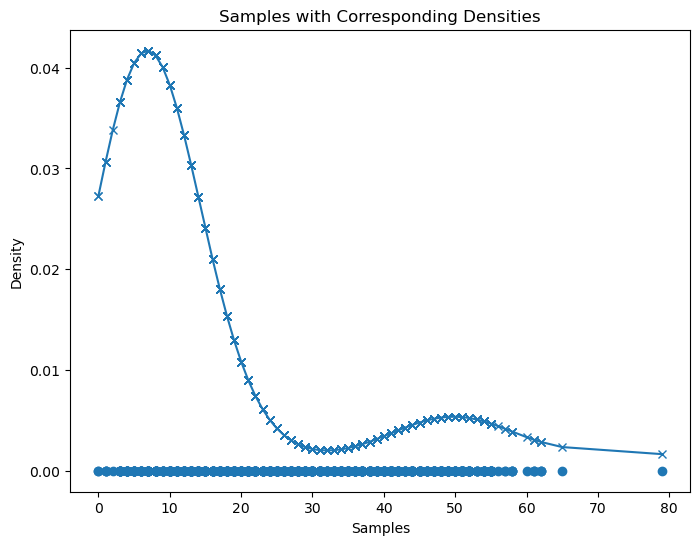

In [318]:
cl=KDE('gaussian')
cl.fit(l_to_rdist[:,1])
out=cl.score_samples(t_to_bdist[:,1])
print((out))
cl.visualise(t_to_bdist[:,1],out)

In [319]:
ind_peak=out.index(max(out))
dist_peak=(t_to_bdist[:,1])[ind_peak]
threshold_vertical=2*dist_peak
print(threshold_vertical)

14


#### So, we can remove the connection between the boxes having the distance greater than threshold.

In [320]:
df['Top_box'] = [([r[1], int(r[0])]) if r[1] <= threshold_vertical else [-1, 0] for r in t_to_bdist]
df['Bottom_box'] = [[r[1], int(r[0])] if r[1] <= threshold_vertical else [-1, 0] for r in b_to_tdist]
df['Left_box'] = [[r[1], int(r[0])] if r[1] <= threshold_horizontal else [-1, 0] for r in l_to_rdist]
df['Right_box'] = [[r[1], int(r[0])] if r[1] <= threshold_vertical else [-1, 0] for r in r_to_ldist]
df['Top'] = df['Top'].apply(lambda x: x.tolist())
df['Bottom']=df['Bottom'].apply(lambda x: x.tolist())
df['Left']=df['Left'].apply(lambda x: x.tolist())
df['Right']=df['Right'].apply(lambda x: x.tolist())
final_df=df[['Id', 'Top-Left', 'Bottom-Right', 'Top', 'Left', 'Bottom', 'Right', 'Top_box', 'Bottom_box', 'Left_box', 'Right_box']]

In [321]:
final_df.to_csv('temp.csv',index=False)

In [ ]:
df = pd.read_csv('temp.csv')
img = cv2.imread('images/250.jpg')
def convert_to_list(s):
    return ast.literal_eval(s)
columns_with_strings = ['Top-Left', 'Bottom-Right', 'Top', 'Left', 'Bottom', 'Right', 'Top_box', 'Bottom_box', 'Left_box', 'Right_box']
for column in columns_with_strings:
    df[column] = df[column].apply(convert_to_list)
new_im=make_connections(img,df)
plt.imshow(new_im)
plt.axis('off')
plt.show()